In [1]:
!pip install pandas numpy requests statsmodels matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [3]:
API_KEY = "e9bfb7aebd996e1733f4cbc5dca132bc"  
BASE_URL = "http://api.marketstack.com/v1/eod"
def get_stock_data(symbol, start_date, end_date):
    """Fetch historical stock prices for a given symbol."""
    params = {
        "access_key": API_KEY,
        "symbols": symbol,
        "date_from": start_date,
        "date_to": end_date,
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    if "data" in data:
        df = pd.DataFrame(data["data"])
        df["date"] = pd.to_datetime(df["date"])
        df = df[["date", "close"]].rename(columns={"date": "Date", "close": "Close_Price"})
        df.sort_values("Date", inplace=True)
        return df
    else:
        print(f"Error fetching data for {symbol}: {data}")
        return pd.DataFrame() 

In [4]:
STOCK_SYMBOLS = ["AAPL", "GOOGL", "MSFT", "TSLA", "AMZN"]
start_date = "2024-02-01"
end_date = "2025-03-10"
stock_data = {}
for stock in STOCK_SYMBOLS:
    stock_data[stock] = get_stock_data(stock, start_date, end_date)
    print(f"✅ {stock} Data Loaded!")
print(stock_data["AAPL"].head())


✅ AAPL Data Loaded!
✅ GOOGL Data Loaded!
✅ MSFT Data Loaded!
✅ TSLA Data Loaded!
✅ AMZN Data Loaded!
                        Date  Close_Price
99 2024-10-14 00:00:00+00:00       231.30
98 2024-10-15 00:00:00+00:00       233.85
97 2024-10-16 00:00:00+00:00       231.78
96 2024-10-17 00:00:00+00:00       232.15
95 2024-10-18 00:00:00+00:00       235.00


In [5]:
df = stock_data["AAPL"].copy()
df.set_index("Date", inplace=True)
model = SARIMAX(df["Close_Price"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 5))
model_fit = model.fit()
future_steps = 5
forecast = model_fit.forecast(steps=future_steps)
forecast_dates = pd.date_range(df.index[-1], periods=future_steps+1, freq="D")[1:]
forecast_df = pd.DataFrame({"Date": forecast_dates, "Predicted_Price": forecast.values})
print(forecast_df)


                       Date  Predicted_Price
0 2025-03-11 00:00:00+00:00       227.365912
1 2025-03-12 00:00:00+00:00       227.248687
2 2025-03-13 00:00:00+00:00       227.149830
3 2025-03-14 00:00:00+00:00       228.549972
4 2025-03-15 00:00:00+00:00       225.939135


In [6]:
actual_df = get_stock_data("AAPL", str(forecast_dates[0].date()), str(forecast_dates[-1].date()))
comparison_df = pd.merge(forecast_df, actual_df, on="Date", how="left").rename(columns={"Close_Price": "Actual_Price"})
comparison_df.dropna(inplace=True)
print(comparison_df)


                       Date  Predicted_Price  Actual_Price
0 2025-03-11 00:00:00+00:00       227.365912        220.84
1 2025-03-12 00:00:00+00:00       227.248687        216.98
2 2025-03-13 00:00:00+00:00       227.149830        209.68
3 2025-03-14 00:00:00+00:00       228.549972        213.49


In [7]:
rmse = np.sqrt(mean_squared_error(comparison_df["Actual_Price"], comparison_df["Predicted_Price"]))
print(f"✅ RMSE for Forecast: {rmse:.2f}")


✅ RMSE for Forecast: 13.04


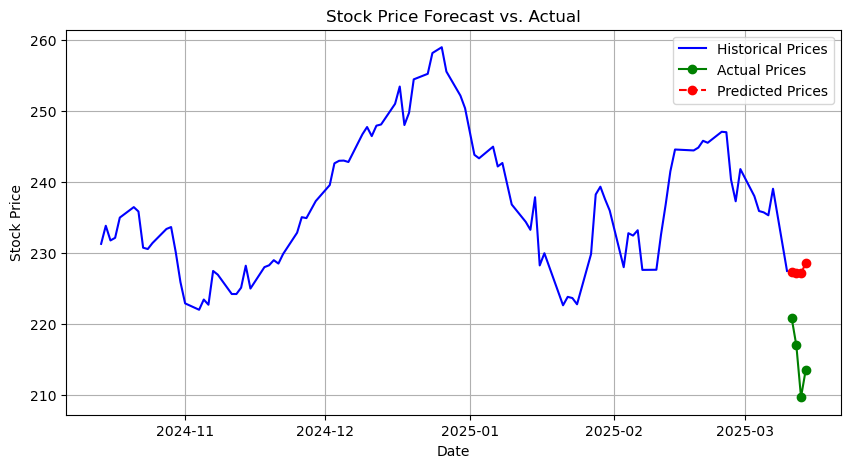

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Close_Price"], label="Historical Prices", color="blue")
plt.plot(comparison_df["Date"], comparison_df["Actual_Price"], label="Actual Prices", color="green", marker="o")
plt.plot(comparison_df["Date"], comparison_df["Predicted_Price"], label="Predicted Prices", color="red", linestyle="dashed", marker="o")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Forecast vs. Actual")
plt.legend()
plt.grid()
plt.show()
